# Open spectrum from root-files
Author:

J. Angevaare // <j.angevaare@nikhef.nl> // 2020-05-25

Until now we have only been dealing with small files that make it easy to see what is going on. Perhaps we want at some point to get more data from the stoomboot computing cluster or the appended root-file as in this folder. This notebook will show how to and we make an exemplary coincidence plot for Ti-44 using much more data than in the previous tutorials.

Below we:
 - locate a file on the stoomboot computing cluster
 - open it using uproot
 - show a calibrated spectrum
 - show a Ti-44 coincidence plot

## Locating file:
check where files live on stoomboot (NB: will only work on stoomboot not on your machine!)


In [1]:
# this is where files are stored (let's "grep" something from january this year)
!ls /data/modulation/Raw_Data/combined/ | grep 202001

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# this is where processed root files live, lets look at the top folder of the list above
!ls -lthr /dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055 | tail -5

ls: cannot access '/dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055': No such file or directory


In [3]:
# Let's copy that last one as it is not too big
!cp '/dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055/mx_n_20200104_1055_000055.root' .

cp: cannot stat '/dcache/xenon/tmons/Modulation/processed/mx_n_20200104_1055/mx_n_20200104_1055_000055.root': No such file or directory


In [4]:
!ls -lthr

total 316K
-rwxrwxrwx 1 joran joran 5.9K May 25 17:20  coincidence_matching.py
-rwxrwxrwx 1 joran joran 181K May 25 18:38 '3. open_raw_root_and_ti44.ipynb'
drwxrwxrwx 1 joran joran 4.0K May 25 18:45  __pycache__
-rwxrwxrwx 1 joran joran 122K May 25 18:45 '2. coincidence_matching_Co60.ipynb'


## Open the data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numba
import uproot

In [4]:
# Let's look at the first root file in the list above
path = '../data/mx_n_20200104_1055_000055.root'

In [5]:
file = uproot.open(path)

In [6]:
tree = file['T;2']

In [7]:
data = tree.pandas.df()

In [8]:
# Let's have a look at how the data looks like
data[['channel', 'integral', 'height', 'time', 'istestpulse', 'error', 'baseline', 'rms', 'ratio', 'humid', 'sec']]

,channel,integral,height,time,istestpulse,error,baseline,rms,ratio,humid,sec
0,5,1258.489746,0.756836,3.787286e+09,0,0,660.000000,8.000000,0.872195,-9.16,12510.0
1,6,1299.349243,1.729395,3.787286e+09,0,1,776.799988,2.993326,0.863694,-9.16,12510.0
2,2,1663.329346,0.942187,3.787286e+09,0,0,721.599976,8.236505,0.880226,-9.16,12510.0
3,3,543.199829,0.382129,3.787286e+09,0,0,661.599976,7.838367,0.861325,-9.16,12510.0
4,4,1328.034302,0.510059,3.787286e+09,0,0,769.599976,1.959592,0.899736,-9.16,12510.0
...,...,...,...,...,...,...,...,...,...,...,...
2329995,3,324.449554,0.265820,3.787288e+09,0,0,674.400024,4.079216,0.888982,-9.16,13742.0
2329996,2,332.196289,0.184961,3.787288e+09,0,0,720.799988,1.600000,0.915332,-9.16,13742.0
2329997,6,658.450928,0.876172,3.787288e+09,0,0,782.400024,6.499231,0.879627,-9.16,13742.0
2329998,7,650.464661,0.844824,3.787288e+09,0,0,723.200012,6.400000,0.882970,-9.16,13742.0


## plot a spectrum of a source, we are starting with Co60!

In [9]:
mask =  (
    (data['channel'] == 4 ) | (data['channel'] == 5 ) 
    & (data['istestpulse'] == 0) 
    & (data['error'] == 0) 
)
co60 = data[mask]

In [10]:
co60

,channel,integral,height,time,istestpulse,error,baseline,rms,ratio,temp,...,humid,sec,hv0,hv1,hv2,hv3,hv4,hv5,hv6,hv7
0,5,1258.489746,0.756836,3.787286e+09,0,0,660.000000,8.000000,0.872195,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
4,4,1328.034302,0.510059,3.787286e+09,0,0,769.599976,1.959592,0.899736,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
9,4,1211.037231,0.442285,3.787286e+09,0,0,768.799988,5.306600,0.901098,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
15,4,893.122253,0.337598,3.787286e+09,0,0,766.400024,5.425864,0.908753,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
16,5,241.214294,0.177051,3.787286e+09,0,0,665.599976,3.200000,0.936039,29.4,...,-9.16,12510.0,619.099976,709.400024,679.400024,699.400024,989.299988,669.000000,659.0,729.099976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2329944,5,1685.615356,1.051758,3.787288e+09,0,0,664.000000,2.529822,0.873661,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976
2329954,4,1170.944702,0.427832,3.787288e+09,0,0,767.200012,2.993326,0.895789,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976
2329955,5,454.636932,0.289746,3.787288e+09,0,0,662.400024,1.959592,0.899825,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976
2329988,4,1015.859863,0.375977,3.787288e+09,0,0,772.000000,4.381781,0.898980,29.4,...,-9.16,13742.0,619.099976,709.400024,679.400024,699.400024,989.200012,668.900024,659.0,729.099976


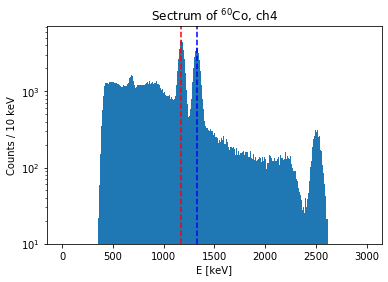

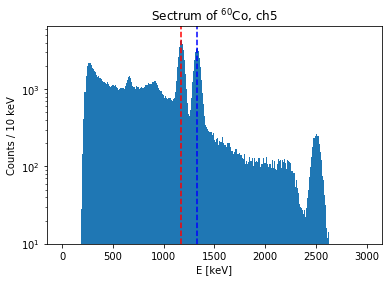

In [11]:
for ch in np.unique(co60['channel']):
    plt.title('Sectrum of ${}^{60}$Co'f', ch{ch}')
    selection = (co60['channel']==ch)
    plt.hist(co60[selection]['integral'].values, bins = 300, range=[0,3000])
    plt.yscale('log')
    plt.ylim(10,plt.ylim()[-1])
    plt.axvline(1173.2, c = 'r', linestyle = '--')
    plt.axvline(1332.5, c = 'b', linestyle = '--')
    plt.xlabel('E [keV]')
    plt.ylabel('Counts / 10 keV')
    plt.show()

## Save small selection
For further use cases we want to save a copy where we have somewhat less data such that we can use this to do small tests with.

This is actually where the CSV file that was used in the previous tutorials was created. You can see that we have capped the max number of events in this file to 100000.

In [23]:
co60[['channel', 'integral','time']][:100000].to_csv('../data/Co60_sample.csv',index=False)

# Ti44

Below, we'll do the same thing as we have done earlier for Co60 in the 3rd session. Now we'll do the same for Ti44 but with much higher statistics!

Can you again explain all of the spectrum we will see below? Good luck!

In [15]:
from coincidence_matching import *

In [16]:
# Let's cut out some data where we are not interested in anyway
mask =  ((data['istestpulse'] == 0)  & (data['error'] == 0) )
data = data[mask]

In [17]:
print(f'Pay attention, we are going to go through quite a lot of data!\n'
      f'The data we are using now is a staggering {len(data)} events (that is ~{int(len(data)/1e6)} million!)')

Pay attention, we are going to go through quite a lot of data!
The data we are using now is a staggering 2293930 events (that is ~2 million!)


In [18]:
%%time
matched_ti44 = easy_coincidence_matching(data, source='Ti44', check_time_order = False)

CPU times: user 2 s, sys: 31.3 ms, total: 2.03 s
Wall time: 2.13 s


In [19]:
%%time
matched_ti44 = easy_coincidence_matching(data, source='Ti44', check_time_order = False)

CPU times: user 838 ms, sys: 4.04 ms, total: 842 ms
Wall time: 841 ms


In [20]:
matched_ti44

,e_ch2,e_ch3,t_ch2,t_ch3
0,1663.329346,543.199829,3.787286e+09,3.787286e+09
1,501.850494,534.243225,3.787286e+09,3.787286e+09
2,668.394592,302.602966,3.787286e+09,3.787286e+09
3,584.177307,1112.822632,3.787286e+09,3.787286e+09
4,1211.873535,651.058533,3.787286e+09,3.787286e+09
...,...,...,...,...
397110,513.559204,848.104431,3.787288e+09,3.787288e+09
397111,500.447906,520.831970,3.787288e+09,3.787288e+09
397112,528.500000,391.742767,3.787288e+09,3.787288e+09
397113,534.476318,517.040833,3.787288e+09,3.787288e+09


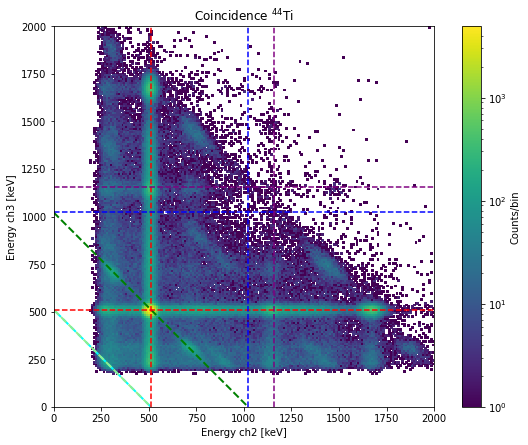

In [21]:
plt.figure(figsize=(10,7))
plt.hist2d(
    matched_ti44['e_ch2'],
    matched_ti44['e_ch3'], 
    bins = 200, 
    norm=LogNorm(),
    range=[[0,2000],[0,2000]]);
plt.plot([511,0], [0,511], linestyle = '--', linewidth = 2, c = 'cyan')
plt.plot([0,511], [511,0], linestyle = '--', linewidth = 2, c = 'lightgreen')
plt.plot([0,511+511], [511+511,0], linestyle = '--', linewidth = 2, c = 'green')
plt.gca().set_aspect(1)
plt.colorbar(label='Counts/bin')
plt.xlabel('Energy ch2 [keV]')
plt.ylabel('Energy ch3 [keV]')
plt.title('Coincidence ${}^{44}$Ti');
plt.axvline(511, c = 'r', linestyle = '--')
plt.axhline(511, c = 'r', linestyle = '--')
plt.axvline(511*2, c = 'b', linestyle = '--')
plt.axhline(511*2, c = 'b', linestyle = '--')
plt.axvline(1157, c = 'purple', linestyle = '--', label = '1157 keV')
plt.axhline(1157, c = 'purple', linestyle = '--', label = '1157 keV')

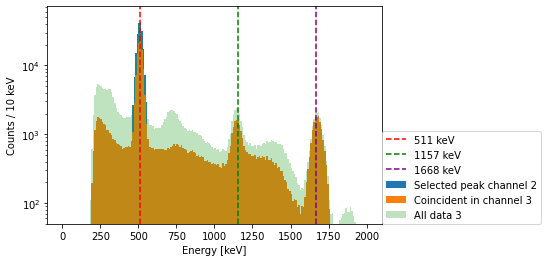

In [22]:
selected_data = select_peak(matched_ti44, 'e_ch2', energy = 511, energy_range = 50)
plt.hist(selected_data['e_ch2'], bins = 200, range=[0,2000], label = 'Selected peak channel 2')
plt.hist(selected_data['e_ch3'], bins = 200, range=[0,2000], label = 'Coincident in channel 3')
plt.hist(matched_ti44['e_ch3'], bins = 200, range=[0,2000], label = 'All data 3', alpha = 0.3)
plt.axvline(511, c = 'r', linestyle = '--', label = '511 keV')
plt.axvline(1157, c = 'green', linestyle = '--', label = '1157 keV')
plt.axvline(1157+511, c = 'purple', linestyle = '--', label = f'{1157+511} keV')
plt.yscale('log')
plt.legend(loc=(1,0))
plt.xlabel('Energy [keV]')
plt.ylabel('Counts / 10 keV')
plt.ylim(ymin=50);